In [2]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # use Agg backend for matplotlib to avoid display issues
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # required if only plt is imported
%matplotlib inline
import seaborn as sns

# SEt default seaborn style
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('./data/salaries.csv')

In [4]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Customer Success Manager,57000,EUR,60000,NL,50,NL,L
1,2025,SE,FT,Engineer,165000,USD,165000,US,0,US,M
2,2025,SE,FT,Engineer,109000,USD,109000,US,0,US,M
3,2025,SE,FT,Applied Scientist,294000,USD,294000,US,0,US,M
4,2025,SE,FT,Applied Scientist,137600,USD,137600,US,0,US,M


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88584 entries, 0 to 88583
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           88584 non-null  int64 
 1   experience_level    88584 non-null  object
 2   employment_type     88584 non-null  object
 3   job_title           88584 non-null  object
 4   salary              88584 non-null  int64 
 5   salary_currency     88584 non-null  object
 6   salary_in_usd       88584 non-null  int64 
 7   employee_residence  88584 non-null  object
 8   remote_ratio        88584 non-null  int64 
 9   company_location    88584 non-null  object
 10  company_size        88584 non-null  object
dtypes: int64(4), object(7)
memory usage: 7.4+ MB


In [6]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,88584.000000,8.858400e+04,88584.000000,88584.000000
mean,2024.034758,1.619323e+05,157567.798417,21.286011
std,0.620370,1.965317e+05,73531.373158,40.831018
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2024.000000,1.060000e+05,106097.250000,0.000000
50%,2024.000000,1.470000e+05,146307.000000,0.000000
75%,2024.000000,1.995000e+05,198600.000000,0.000000
max,2025.000000,3.040000e+07,800000.000000,100.000000


# Data Cleaning and Preprocessing

Before diving deep into the analysis, it is essential to ensure the data is clean and ready. In this section, we inspect for missing values, duplicates, and ensure that data types are correctly set. If you ever encounter errors due to misinterpreted data types or unexpected null values, the methods demonstrated here serve as a good starting point for resolution.

In [7]:
print('Missing values per column:')
display(df.isnull().sum())

# If duplicates exist, drop them
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f'Number of duplicate rows removed: {initial_shape[0] - df.shape[0]}')

# Comfirm data types
print('\nData types after cleaning:')
display(df.dtypes)

Missing values per column:


work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

Number of duplicate rows removed: 44340

Data types after cleaning:


work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

# Exploratory Data Analysis

Now we dig into the data with several visualization techniques. We explore the distributions and relationships within the dataset through histograms, box plots, and heatmaps. Our visualizations include heatmaps to assess correlations, while pair plots and various categorical plots help us understand feature distributions. A dry observation: sometimes the data reveals more secrets than an overused dataset ever could.

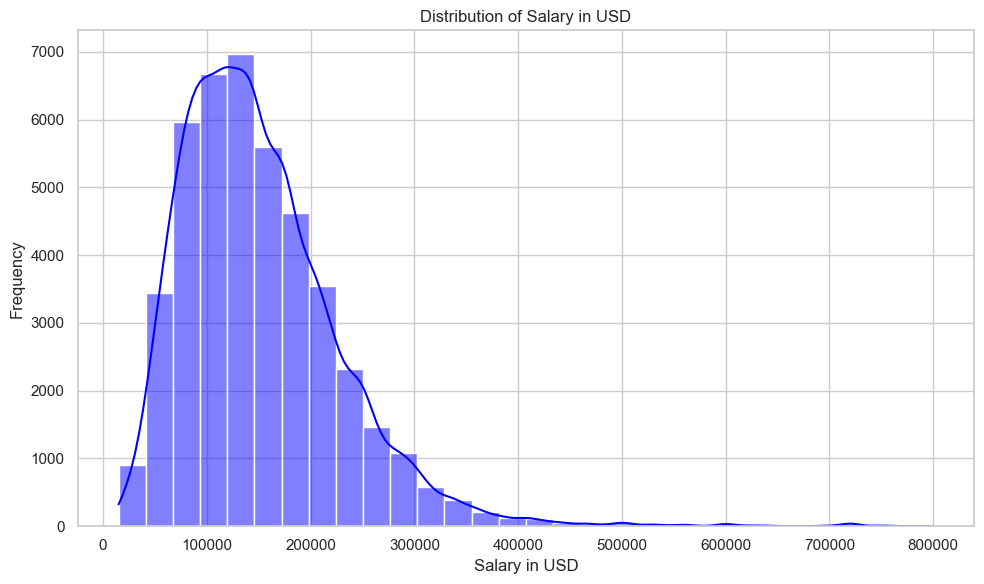

C:\Users\NMH\AppData\Local\Temp\ipykernel_1852\623183285.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='experience_level', palette='viridis')


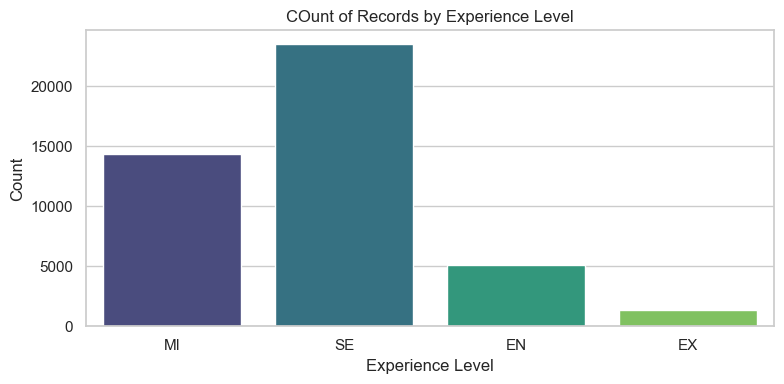

C:\Users\NMH\AppData\Local\Temp\ipykernel_1852\623183285.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='remote_ratio', y='salary_in_usd', palette="Set2")


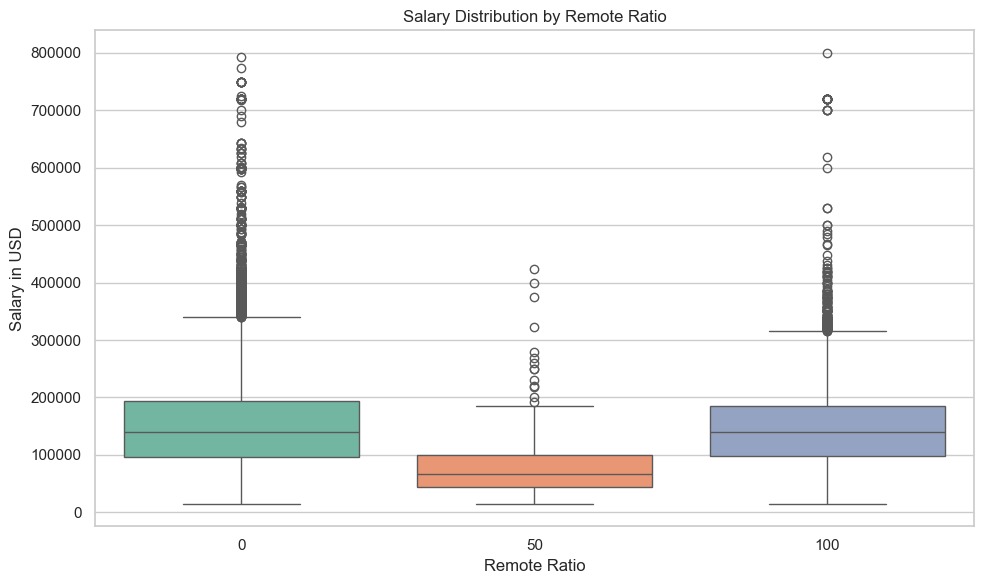

In [8]:
# Histogram for Salary in USA
plt.figure(figsize=(10,6))
sns.histplot(df['salary_in_usd'], kde=True, bins=30, color='blue')
plt.title('Distribution of Salary in USD')
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Count plot for Experience Level
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='experience_level', palette='viridis')
plt.title('COunt of Records by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Box plot for Salary in USD vs Remote Ratio
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='remote_ratio', y='salary_in_usd', palette="Set2")
plt.title('Salary Distribution by Remote Ratio')
plt.xlabel('Remote Ratio')
plt.ylabel('Salary in USD')
plt.tight_layout()
plt.show()

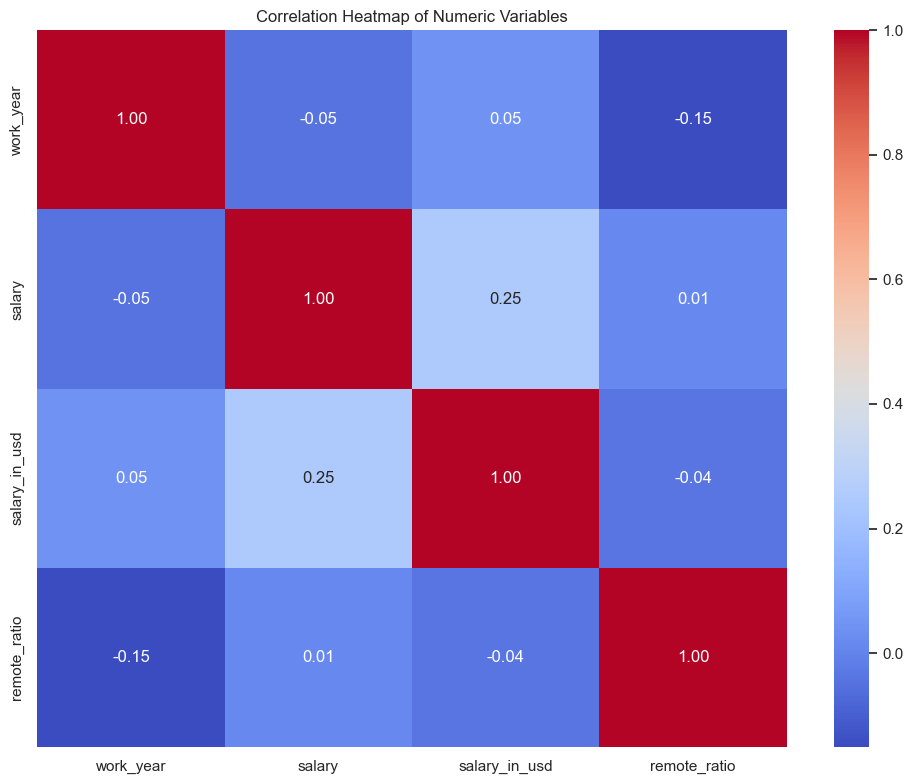

In [11]:
# Correlation heatmap for Numeric Columns
# We filter only numeric types
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
  plt.figure(figsize=(10,8))
  sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.title('Correlation Heatmap of Numeric Variables')
  plt.tight_layout()
  plt.show()
else:
  print('Not enough numeriv columns for a correlation heatmap.')  

# Predictor Creation

Based on the dataset, creating a predictor for salary_in_usd seems appropriate. In this section, we build a simple regression model (Linear Regression) to predict the salary in USD. We consider a subset of features that are likely to impact salary such as work_year, experience_level, employment_type, remote_ratio, and company_size. Categorical variables are handled via one-hot encoding.

Note: In cases where encoding errors might arise due to unexpected categories, using pandas' get_dummies with drop_first can help mitigate potential multicollinearity issues

In [12]:
# Predictor Creation
# Selecting features for prediction
features = ['work_year', 'experience_level', 'employment_type', 'remote_ratio', 'company_size']
X = df[features]
y = df['salary_in_usd']

# Convert Categorical variables using one-hot encoding]
X = pd.get_dummies(X, drop_first=True)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluate the model using R-squared metric
r2 = r2_score(y_test, y_pred)
print(f'R-squared score of the model: {r2:.4f}')

R-squared score of the model: 0.1211


# Conclusion and Future Work

In summary, our analysis covered several exploratory techniques to understand the trends in global AI and ML salaries, and we successfully built a basic regression model to predict salary in USD. The multi-faceted approach using both visualization and predictive modeling can be expanded further with more complex algorithms or a deeper feature engineering process. Future work might involve:

Experimenting with more sophisticated regression models
Incorporating additional data sources
Refining feature selection and engineering to better capture non-linear relationships
Thank you for exploring this notebook. If you found it useful, your upvote is appreciated.